In [1]:
!git clone https://github.com/ConstBob/taming-transformers
%cd taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1233, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1233 (delta 0), reused 0 (delta 0), pack-reused 1228 (from 1)
Receiving objects: 100% (1233/1233), 148.33 MiB | 51.00 MiB/s, done.
Resolving deltas: 100% (256/256), done.
/content/taming-transformers


In [2]:
# download a VQGAN with f=16 (16x compression per spatial dimension) and with a codebook with 1024 entries
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml'

--2025-01-08 17:34:04--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/38fd1d07-fd75-4bc5-a438-5071ff23bdf0/last.ckpt [following]
--2025-01-08 17:34:05--  https://heibox.uni-heidelberg.de/seafhttp/files/38fd1d07-fd75-4bc5-a438-5071ff23bdf0/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 913.58M  8.49MB/s    in 1m 53s  

2025-01-08 17:35:58 (8.11 MB/s) - ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’ saved [957954257/957954257]

--2025-01-08 17:35:58--  h

In [3]:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec, indices

In [5]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 188MB/s]


8.19kB [00:00, 37.7kB/s]                            
/content/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
%pip install git+https://github.com/openai/DALL-E.git &> /dev/null

import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle:
      img = map_pixels(img)
    return img


In [7]:
# Load 200 samples from DIV2K and process
!mkdir -p /content/DIV2K
!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -O /content/DIV2K/DIV2K_train_HR.zip
!unzip -q /content/DIV2K/DIV2K_train_HR.zip -d /content/DIV2K/


--2025-01-08 17:36:32--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘/content/DIV2K/DIV2K_train_HR.zip’

/content/DIV2K/DIV2 100%[===================>]   3.29G  28.1MB/s    in 2m 1s   

2025-01-08 17:38:34 (27.9 MB/s) - ‘/content/DIV2K/DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [8]:
from google.colab import drive
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import requests
import os
import random
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def load_image(source):
    if os.path.isfile(source):
        return PIL.Image.open(source)

Mounted at /content/drive
Processing image 1/200: /content/DIV2K/DIV2K_train_HR/0448.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Processing image 2/200: /content/DIV2K/DIV2K_train_HR/0729.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Processing image 3/200: /content/DIV2K/DIV2K_train_HR/0246.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Processing image 4/200: /content/DIV2K/DIV2K_train_HR/0571.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Processing image 5/200: /content/DIV2K/DIV2K_train_HR/0068.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Processing image 6/200: /content/DIV2K/DIV2K_train_HR/0381.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size(

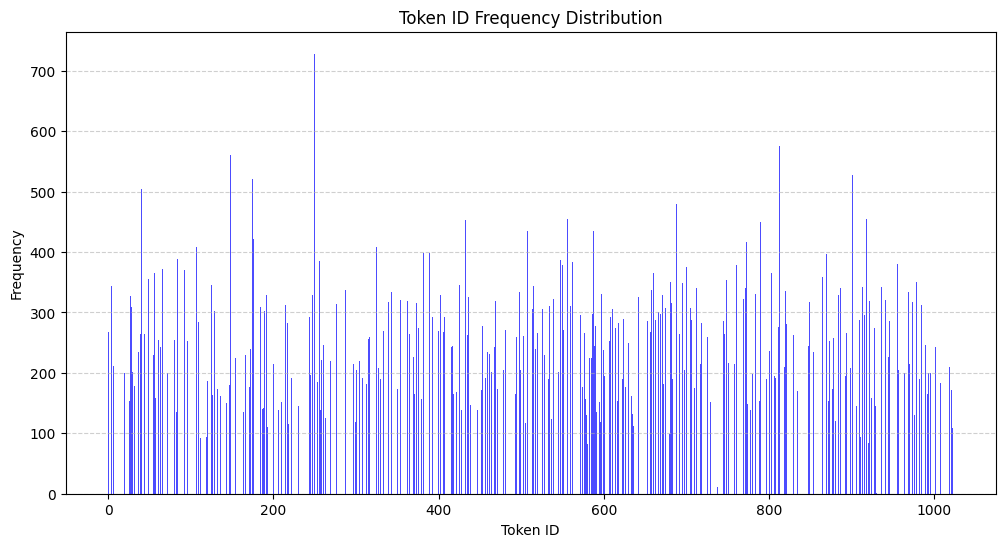

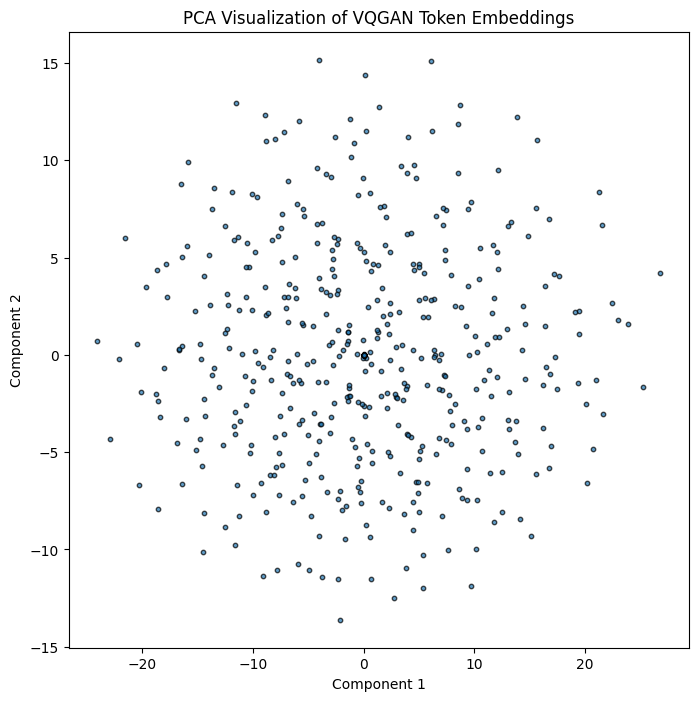

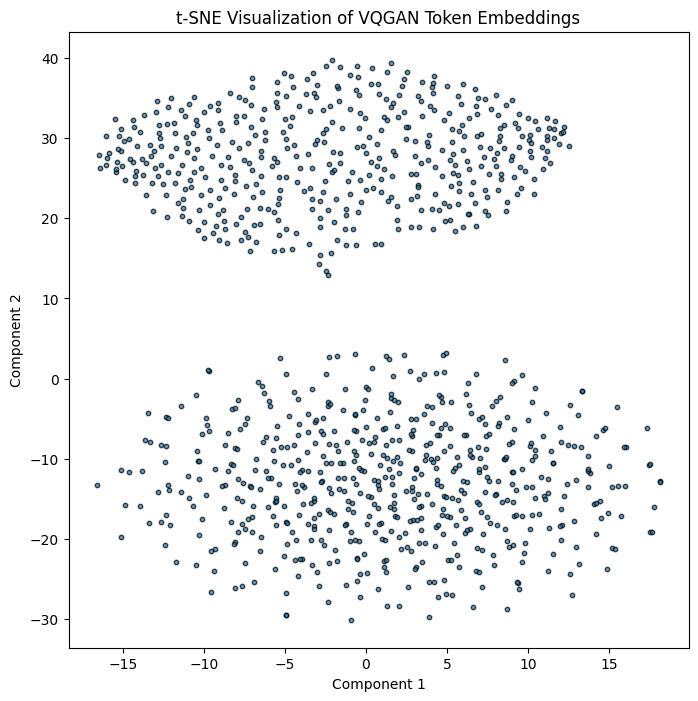

In [10]:
# Mount Google Drive
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/DIV2K_output"
os.makedirs(output_dir, exist_ok=True)
original_images_dir = os.path.join(output_dir, "original_images")
reconstructed_images_dir = os.path.join(output_dir, "reconstructed_images")
data_save_dir = os.path.join(output_dir, "data")
os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(reconstructed_images_dir, exist_ok=True)
os.makedirs(data_save_dir, exist_ok=True)

# Path to the dataset
data_dir = "/content/DIV2K/DIV2K_train_HR"

# Reconstruct sample images

titles=["Input", "VQGAN (f16, 1024)"]

def reconstruction_pipeline_samples(image_path, size=384):
    image_id = os.path.basename(image_path).split('.')[0]
    x_vqgan = preprocess(load_image(image_path), target_image_size=size, map_dalle=False)
    x_vqgan = x_vqgan.to(DEVICE)

    print(f"input is of size: {x_vqgan.shape}")
    x2, indices = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)

    # Save original image
    img_original = custom_to_pil(preprocess_vqgan(x_vqgan[0]))
    img_original.save(os.path.join(original_images_dir, f"{image_id}_original.png"))

    # Save reconstructed image
    img_reconstructed = custom_to_pil(x2[0])
    img_reconstructed.save(os.path.join(reconstructed_images_dir, f"{image_id}_reconstructed.png"))

    # # Save token indices
    # indices_path = os.path.join(data_save_dir, f"{image_id}_indices.json")
    # with open(indices_path, "w") as f:
    #     json.dump(indices.tolist(), f)  # Ensure indices are converted to list

    return indices

# Save embeddings and dimensionality reduction

def save_embeddings_and_reduce(model, save_path):
    embeddings = model.quantize.embedding.weight.detach().cpu().numpy()
    np.save(os.path.join(save_path, "vqgan_embeddings.npy"), embeddings)

    # Perform PCA
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    np.save(os.path.join(save_path, "vqgan_embeddings_pca.npy"), embeddings_pca)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)
    np.save(os.path.join(save_path, "vqgan_embeddings_tsne.npy"), embeddings_tsne)

    # Visualize PCA and t-SNE
    def plot_embeddings(data, method_name, save_path):
        plt.figure(figsize=(8, 8))
        plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.7, edgecolor='k')
        plt.title(f"{method_name} Visualization of VQGAN Token Embeddings")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.savefig(os.path.join(save_path, f"vqgan_embeddings_{method_name.lower()}.png"))
        plt.show()

    plot_embeddings(embeddings_pca, "PCA", save_path)
    plot_embeddings(embeddings_tsne, "t-SNE", save_path)


# Ensure the dataset exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"DIV2K data directory not found: {data_dir}")

# Collect all image paths
all_images = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(".png") or img.endswith(".jpg")]

sample_size = 200

if len(all_images) < sample_size:
    raise ValueError("Not enough images in the dataset to sample images.")

sampled_images = random.sample(all_images, sample_size)

indices_list = []
all_tokens = []

# Processing the sampled images
for idx, image_path in enumerate(sampled_images):
    print(f"Processing image {idx + 1}/{sample_size}: {image_path}")
    indices = reconstruction_pipeline_samples(image_path)
    indices_list.append({
        "image_id": os.path.basename(image_path).split('.')[0],
        "indices": indices.tolist()  # Convert Tensor to list
    })
    # Ensure tokens are moved to CPU and converted to numpy
    all_tokens.extend(indices.cpu().numpy().flatten())

# Save token ID frequency distribution
unique, counts = np.unique(all_tokens, return_counts=True)
token_distribution = dict(zip(unique.tolist(), counts.tolist()))
with open(os.path.join(data_save_dir, "token_distribution.json"), "w") as f:
    json.dump(token_distribution, f)

# Visualize token ID frequency distribution
def plot_token_distribution(token_distribution, save_path):
    import matplotlib.pyplot as plt

    # Convert distribution to sorted lists
    tokens, frequencies = zip(*sorted(token_distribution.items(), key=lambda x: x[0]))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, frequencies, color='blue', alpha=0.7)
    plt.title("Token ID Frequency Distribution")
    plt.xlabel("Token ID")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(save_path, "token_id_frequency_distribution.png"))
    plt.show()

plot_token_distribution(token_distribution, data_save_dir)

# Save all indices data
data_summary_path = os.path.join(data_save_dir, "all_indices.json")
with open(data_summary_path, "w") as f:
    json.dump(indices_list, f)

# Save embeddings and dimensionality reduction results
save_embeddings_and_reduce(model1024, data_save_dir)


Generated similar image saved at: /content/drive/MyDrive/DIV2K_output/data/similar_image.png
/content/DIV2K/DIV2K_train_HR/0448.png
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
Difference matrix saved at: /content/drive/MyDrive/DIV2K_output/data/difference_matrix.npy


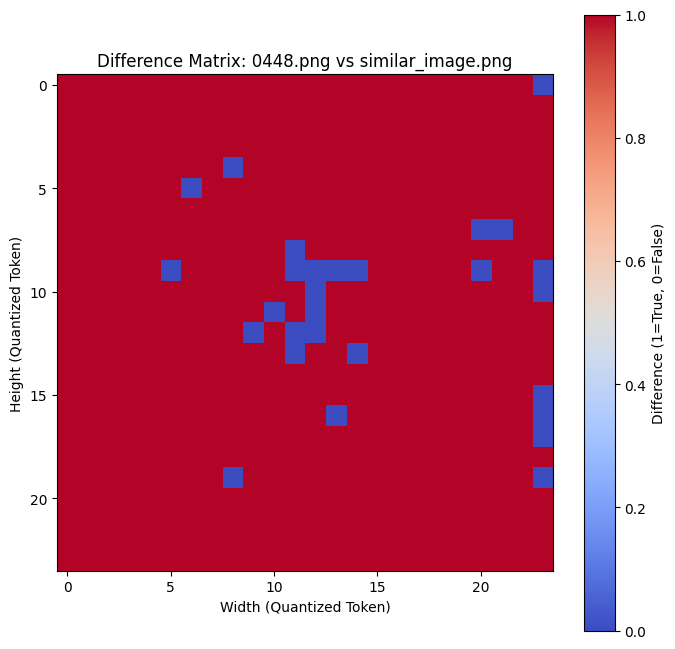

Difference visualization saved at: /content/drive/MyDrive/DIV2K_output/data/difference_matrix_visualization.png
Total Tokens: 576, Changed Tokens: 548 (95.14%)
Unique Token IDs in Image 1 causing differences: [   0    4    7   12   20   26   27   28   29   31   32   35   36   37
   39   48   54   55   56   63   66   80   82   84   94   96  107  109
  110  112  117  119  120  125  126  128  129  136  147  148  150  156
  166  168  171  173  175  176  185  186  188  192  193  208  219  225
  226  237  247  250  253  254  257  258  260  263  269  283  295  297
  301  304  306  308  313  315  323  325  327  333  334  343  354  358
  363  365  370  371  373  376  382  389  393  402  404  406  407  417
  418  425  426  428  432  433  435  436  437  439  444  447  450  452
  453  460  464  468  469  477  481  483  494  499  505  508  514  515
  517  519  520  528  534  537  539  541  542  545  546  548  550  551
  553  556  558  560  562  564  574  575  576  579  580  582  583  585
  586  587

In [19]:
# Compare two similar images

def create_similar_image(original_image_path, save_path):
    """
    Create a slightly modified version of the original image.
    Example modification: Add Gaussian noise and slight rotation.
    """
    original_image = load_image(original_image_path)
    original_image = original_image.convert("RGB")
    original_array = np.array(original_image, dtype=np.float32) / 255.0

    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, original_array.shape)  # Mean=0, Std=0.05
    modified_array = np.clip(original_array + noise, 0, 1)  # Clip to valid range [0, 1]

    # Convert back to image
    modified_image = Image.fromarray((modified_array * 255).astype(np.uint8))

    # Apply slight rotation
    modified_image = modified_image.rotate(3, resample=Image.BICUBIC)

    modified_image.save(save_path)

    print(f"Generated similar image saved at: {save_path}")
    return save_path

def visualize_difference(diff, image_path1, image_path2, save_dir):
    """
    Visualize the difference matrix between two images.

    Parameters:
    - diff (numpy.ndarray): Boolean matrix indicating differences.
    - image_path1 (str): Path to the first image.
    - image_path2 (str): Path to the second image.
    - save_dir (str): Directory to save the visualization.
    """
    # Ensure the difference matrix is 2D
    if len(diff.shape) != 2:
        diff = diff.reshape(24, 24)  # Adjust based on the token grid size

    plt.figure(figsize=(8, 8))
    plt.imshow(diff, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Difference (1=True, 0=False)")
    plt.title(f"Difference Matrix: {os.path.basename(image_path1)} vs {os.path.basename(image_path2)}")
    plt.xlabel("Width (Quantized Token)")
    plt.ylabel("Height (Quantized Token)")
    diff_image_path = os.path.join(save_dir, "difference_matrix_visualization.png")
    plt.savefig(diff_image_path)
    plt.show()
    print(f"Difference visualization saved at: {diff_image_path}")


def analyze_differences(indices1, indices2, diff):
    # Calculate the total number of tokens and the number of differing tokens
    total_tokens = diff.size
    changed_tokens = np.sum(diff)
    print(f"Total Tokens: {total_tokens}, Changed Tokens: {changed_tokens} ({(changed_tokens / total_tokens) * 100:.2f}%)")

    # Identify unique token IDs contributing to differences in each image
    unique_diff_ids1 = np.unique(indices1[diff])
    unique_diff_ids2 = np.unique(indices2[diff])
    print(f"Unique Token IDs in Image 1 causing differences: {unique_diff_ids1}")
    print(f"Unique Token IDs in Image 2 causing differences: {unique_diff_ids2}")


def compare_images(image_path1, image_path2):
    quantized_ids_save_dir = os.path.join(data_save_dir, "quantized_token_ids")
    os.makedirs(quantized_ids_save_dir, exist_ok=True)
    indices1 = reconstruction_pipeline_samples(image_path1)
    indices2 = reconstruction_pipeline_samples(image_path2)

    # Move to CPU and convert to NumPy arrays
    indices1 = indices1.cpu().numpy()
    indices2 = indices2.cpu().numpy()

    # Compute difference
    diff = indices1 != indices2
    diff_path = os.path.join(data_save_dir, "difference_matrix.npy")
    np.save(diff_path, diff)

    print(f"Difference matrix saved at: {diff_path}")

    # Visualize the difference matrix
    visualize_difference(diff, image_path1, image_path2, data_save_dir)
    analyze_differences(indices1, indices2, diff)
    return diff




# Compare two similar images
if len(sampled_images) >= 2:
    # Generate a similar image for the first image in the sampled set
    similar_image_path = os.path.join(data_save_dir, "similar_image.png")
    create_similar_image(sampled_images[0], similar_image_path)
    print(sampled_images[0])
    # Compare the original image and the similar image
    compare_images(sampled_images[0], similar_image_path)